In [1]:
import numpy  as np
import pandas as pd
import math
import random
import os
from scipy.special import gamma
import matplotlib.pyplot as plt
from numpy import array, sin, cos, exp, sqrt, pi,abs

In [2]:
#Test functions
def easom(variables_values = [0, 0]):
        return -math.cos(variables_values[0])*math.cos(variables_values[1])*math.exp(-(variables_values[0] - math.pi)**2 - (variables_values[1] - math.pi)**2)

def beale(variables_values=[0,0]):
        tmp1 = np.power(1.5 - variables_values[0] + variables_values[0] * variables_values[1],2)
        tmp2 = np.power(2.25 - variables_values[0] + variables_values[0] * np.power(variables_values[1],2),2)
        tmp3 = np.power(2.625 - variables_values[0] + variables_values[0] * np.power(variables_values[1],3),2)
        return tmp1+tmp2+tmp3

def levy13(variables_values = [0, 0]):
        temp1 = (sin(3 * pi * variables_values[0]) ** 2)
        temp2 = (variables_values[0] - 1) ** 2 * (1 + (sin(3 * pi * variables_values[1])) ** 2)
        temp3 = (variables_values[1] - 1) ** 2 * (1 + (sin(2 * pi * variables_values[1])) ** 2)

        return temp1 + temp2 + temp3

def target_function(params=[]):
    return

## Whale Algorithm


In [3]:
def whale_initial_position(hunting_party = 5, min_values = [-5,-5], max_values = [5,5], target_function = target_function):
    positions = np.zeros((hunting_party,len(min_values)+1))
    for i in range(hunting_party):
        for j in range(len(min_values)):
            positions[i][j] = random.uniform(min_values[j],max_values[j])
        positions[i][len(min_values)] = target_function(positions[i][:len(min_values)])
    return positions



def whale_leader_position(dimension = 2, target_function = target_function):
    leader = np.zeros((1, dimension+1))
    for j in range(dimension):
        leader[0,j] = 0.0
    leader[0,-1] = target_function(leader[0,:dimension])
    return leader


def whale_update_leader(position, leader):
    for i in range(position.shape[0]):
        if (leader[0,-1] > position[i,-1]):
            for j in range(position.shape[1]):
                leader[0,j] = position[i,j]
    return leader


def whale_update_position(position, leader, a_linear_component=2,b_linear_component=1,spiral_param=1,min_values=[-5,-5],max_values=[5,5],target_function=target_function):
    for i in range(position.shape[0]):
        r1_leader = int.from_bytes(os.urandom(8), byteorder = "big") / ((1 << 64) - 1) # uniform random number between 0 and 1
        r2_leader = int.from_bytes(os.urandom(8), byteorder = "big") / ((1 << 64) - 1) # uniform random number between 0 and 1
        a_leader = 2*a_linear_component*r1_leader - a_linear_component # uniform random number between -1 and 1
        c_leader = 2*r2_leader 
        p = int.from_bytes(os.urandom(8), byteorder = "big") / ((1 << 64) - 1)
        for j in range(len(min_values)):
            if(p < 0.5):
                if(abs(a_leader) >= 1):
                    rand = int.from_bytes(os.urandom(8), byteorder = "big") / ((1 << 64) - 1)
                    rand_leader_index = math.floor(position.shape[0]*rand)
                    x_rand = position[rand_leader_index,:]
                    distance_x_rand   = abs(c_leader*x_rand[j] - position[i,j])
                    position[i][j] = np.clip( x_rand[j] - a_leader*distance_x_rand, min_values[j], max_values[j])
                elif(abs(a_leader) < 1):
                    distance_leader   = abs(c_leader*leader[0,j] - position[i,j]) # distance between leader and current position
                    position[i][j] = np.clip( leader[0,j] - a_leader*distance_leader, min_values[j], max_values[j])
            elif(p >= 0.5):
                distance_leader = abs(leader[0,j] - position[i,j]) # distance between leader and current position
                rand = int.from_bytes(os.urandom(8), byteorder = "big") / ((1 << 64) - 1)
                m_param = (b_linear_component - 1)*rand + 1
                position[i][j] = np.clip((distance_leader*math.exp(spiral_param*m_param)*math.cos(m_param*2*math.pi)+leader[0,j]), min_values[j], max_values[j])
        position[i][-1] = target_function(position[i][:len(min_values)])
    return position

    

def whale_optimization_algorithm(hunting_party = 10, spiral_param = 1,  min_values = [-5,-5], max_values = [5,5], iterations = 50,step = 50, target_function = target_function):
    count    = 0
    hist     = []
    leader_plot = []
    positions = whale_initial_position(hunting_party=hunting_party, min_values=min_values, max_values=max_values, target_function=target_function)
    leader = whale_leader_position(dimension=len(min_values), target_function=target_function)
    while(count<iterations):
        # print("Iteration",count,"f(x) =",leader[0,-1])
        #append leaders x,y position to plot
        leader_plot.append(list(leader[0,:len(min_values)]))
        plt.show()
        hist.append(leader[0,-1])
        a_linear_component = 2 - count*(2/iterations) # linear component of a
        b_linear_component = -1 + count*(-1/iterations) # linear component of b
        leader = whale_update_leader(positions, leader)
        positions = whale_update_position(positions, leader, a_linear_component=a_linear_component,b_linear_component=b_linear_component,spiral_param=spiral_param,min_values=min_values,max_values=max_values,target_function=target_function)
        count += 1
    return leader, hist, leader_plot
    

## FireFly Algorithm

In [32]:
def initial_fireflies(swarm_size = 3, min_values = [-5,-5], max_values = [5,5], target_function = target_function):
    position = np.zeros((swarm_size,len(min_values)+1))
    for i in range(swarm_size):
        for j in range(len(min_values)):
            position[i][j] = random.uniform(min_values[j],max_values[j])
        position[i][len(min_values)] = target_function(position[i][:len(min_values)])
    return position

def euclidean_distence(x,y):
    return np.sqrt(np.sum((x-y)**2))

def light_value(light_0,x,y,gama=1):
    rij = euclidean_distence(x,y)
    light = light_0*math.exp(-gama*(rij)**2)
    return light

def beta_value(x,y,gama=1,beta_0=1):
    rij = euclidean_distence(x,y)
    beta = beta_0*math.exp(-gama*(rij)**2)
    return beta

def firefly_update_position(position,x,y,alpha_0=0.2,beta_0 = 1, gama = 1, firefly = 0, min_values = [-5,-5], max_values = [5,5], target_function = target_function):
    for j in range(len(x)):
        epson = int.from_bytes(os.urandom(8), byteorder = "big") / ((1 << 64) - 1)
        position[firefly,j] = np.clip((x[j]+beta_value(x,y,gama=gama,beta_0=beta_0)*(y[j]-x[j])+alpha_0*epson), min_values[j], max_values[j])
    position[firefly,-1] = target_function(position[firefly, 0:position.shape[1]-1])
    return position

def firefly_algorithm(swarm_size = 3,min_values = [-5,-5], max_values = [5,5], generations = 50, alpha_0 = 0.2, beta_0 = 1, gama = 1, target_function = target_function):
    count = 0
    hist = []
    positions = initial_fireflies(target_function=target_function)
    while(count<=generations):
        # print("Generation :",count,"f(x) = ",positions[positions[:,-1].argsort()][0,:][-1])
        for i in range(swarm_size):
            for j in range(swarm_size):
                if(i != j):
                    firefly_i = np.copy(positions[i,0:len(min_values)])
                    firefly_j = np.copy(positions[j,0:len(min_values)])
                    light_i = light_value(positions[i,-1],firefly_i,firefly_j,gama)
                    light_j = light_value(positions[j,-1],firefly_j,firefly_i,gama)
                    if(light_i > light_j):
                        positions = firefly_update_position(positions,firefly_i,firefly_j,alpha_0=alpha_0,beta_0=beta_0,gama=gama,firefly=i,min_values=min_values,max_values=max_values,target_function=target_function)

        count += 1
        best_firefly = np.copy(positions[positions[:,-1].argsort()][0,:])
        hist.append(best_firefly[-1])
    return best_firefly, hist
                    

Firefly Optimization Algorithm
Best Position : [ 1.9110917   2.7643528  -0.05920978]
Best Value : -0.05920977889017375


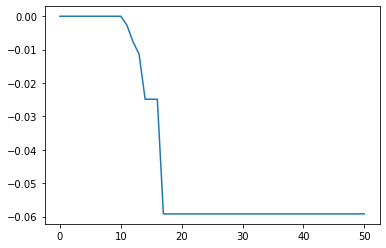

In [45]:
foa,foahist=firefly_algorithm(target_function=easom)
print("Firefly Optimization Algorithm")
print("Best Position :",foa)
print("Best Value :",foa[-1])
plt.plot(foahist)

WOA: [[2.99923123e+00 4.99986071e-01 8.14709238e-07]]


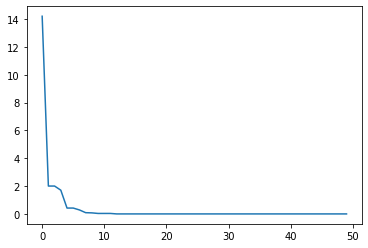

In [18]:
woa,woahist,woaleader_plot=whale_optimization_algorithm(target_function=beale)
print("WOA:",woa)

#plot the histogram of the WOA
plt.plot(woahist)
plt.show()


# for i in range(len(woaleader_plot)):
#     plt.xlim(-5,5)
#     plt.ylim(-5,5)
#     plt.scatter(woaleader_plot[i][0],woaleader_plot[i][1],c='r')
#     plt.pause(0.5)

# plt.show()



## WhaleFireFly Hybrid Algorithm

In [4]:
def hybrid_initital_position(hunting_party=5, min_values=[-5, -5], max_values=[5, 5], target_function=target_function):
    positions = np.zeros((hunting_party, len(min_values)+1))
    for i in range(hunting_party):
        for j in range(len(min_values)):
            positions[i][j] = random.uniform(min_values[j], max_values[j])
        positions[i][len(min_values)] = target_function(positions[i][:len(min_values)])
    return positions

def hybrid_whale_leader(dimension=2, target_function=target_function):
    leader = np.zeros((1, dimension+1))
    for i in range(dimension):
        leader[0][i] = random.uniform(-5, 5)
    leader[0][dimension] = target_function(leader[0][:dimension])
    return leader


def hybrid_update_leader(positions, leader):
    for i in range(positions.shape[0]):
        if (leader[0, -1] > positions[i, -1]):
            for j in range(positions.shape[1]):
                leader[0, j] = positions[i, j]
    return leader

def hybrid_update_position(positions, leader, spiral_param=1, a_linear_component=2, b_linear_component=1,alpha_0=0.2, beta_0=1, gama=1, min_values=[-5, -5], max_values=[5, 5], target_function=target_function):
    for i in range(positions.shape[0]):
        r1_leader = int.from_bytes(os.urandom(8), byteorder="big") / ((1 << 64) - 1)
        # uniform random number between 0 and 1
        r2_leader = int.from_bytes(os.urandom(8), byteorder="big") / ((1 << 64) - 1)
        a_leader = 2*a_linear_component*r1_leader - a_linear_component
        c_leader = 2*r2_leader

        p = int.from_bytes(os.urandom(8), byteorder="big") / ((1 << 64) - 1)
        # Need to continue from here


def whalefireflyhybrid(huntingparty=5,spiral_param=1, min_values=[-5, -5], max_values=[5, 5], generations=50, alpha_0=0.2, beta_0=1, gama=1, target_function=target_function):
    count = 0
    positions = hybrid_initital_position(hunting_party=huntingparty, min_values=min_values, max_values=max_values, target_function=target_function)
    leader = hybrid_whale_leader(dimension=len(min_values), target_function=target_function)

    while(count<=generations):
        a_linear_component = 2 - count*(2/generations)  # linear component of a
        b_linear_component = -1 + count * (-1/generations)  # linear component of b
        leader = hybrid_update_leader(positions, leader)
        

